# Import library and Data Analysis






In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization, Input
from keras.optimizers import Adam
from keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental import preprocessing
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import mixed_precision
mixed_precision.set_global_policy('float32')


print(tf.__version__)

2.15.0


Loading dataset

In [3]:
# Define dataset paths
dataset = {
            "train_data" : "/content/drive/MyDrive/Original data/data original/train",
             "valid_data" : "/content/drive/MyDrive/Original data/data original/valid",
             "test_data" : "/content/drive/MyDrive/Original data/data original/test"
}


all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)


    all_data.append(data.copy())
    data.clear()



train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))
test_df = pd.DataFrame(all_data[2] , index=range(len(all_data[2]['imgpath'])))


# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])
test_df['encoded_labels'] = lb.fit_transform(test_df['labels'])

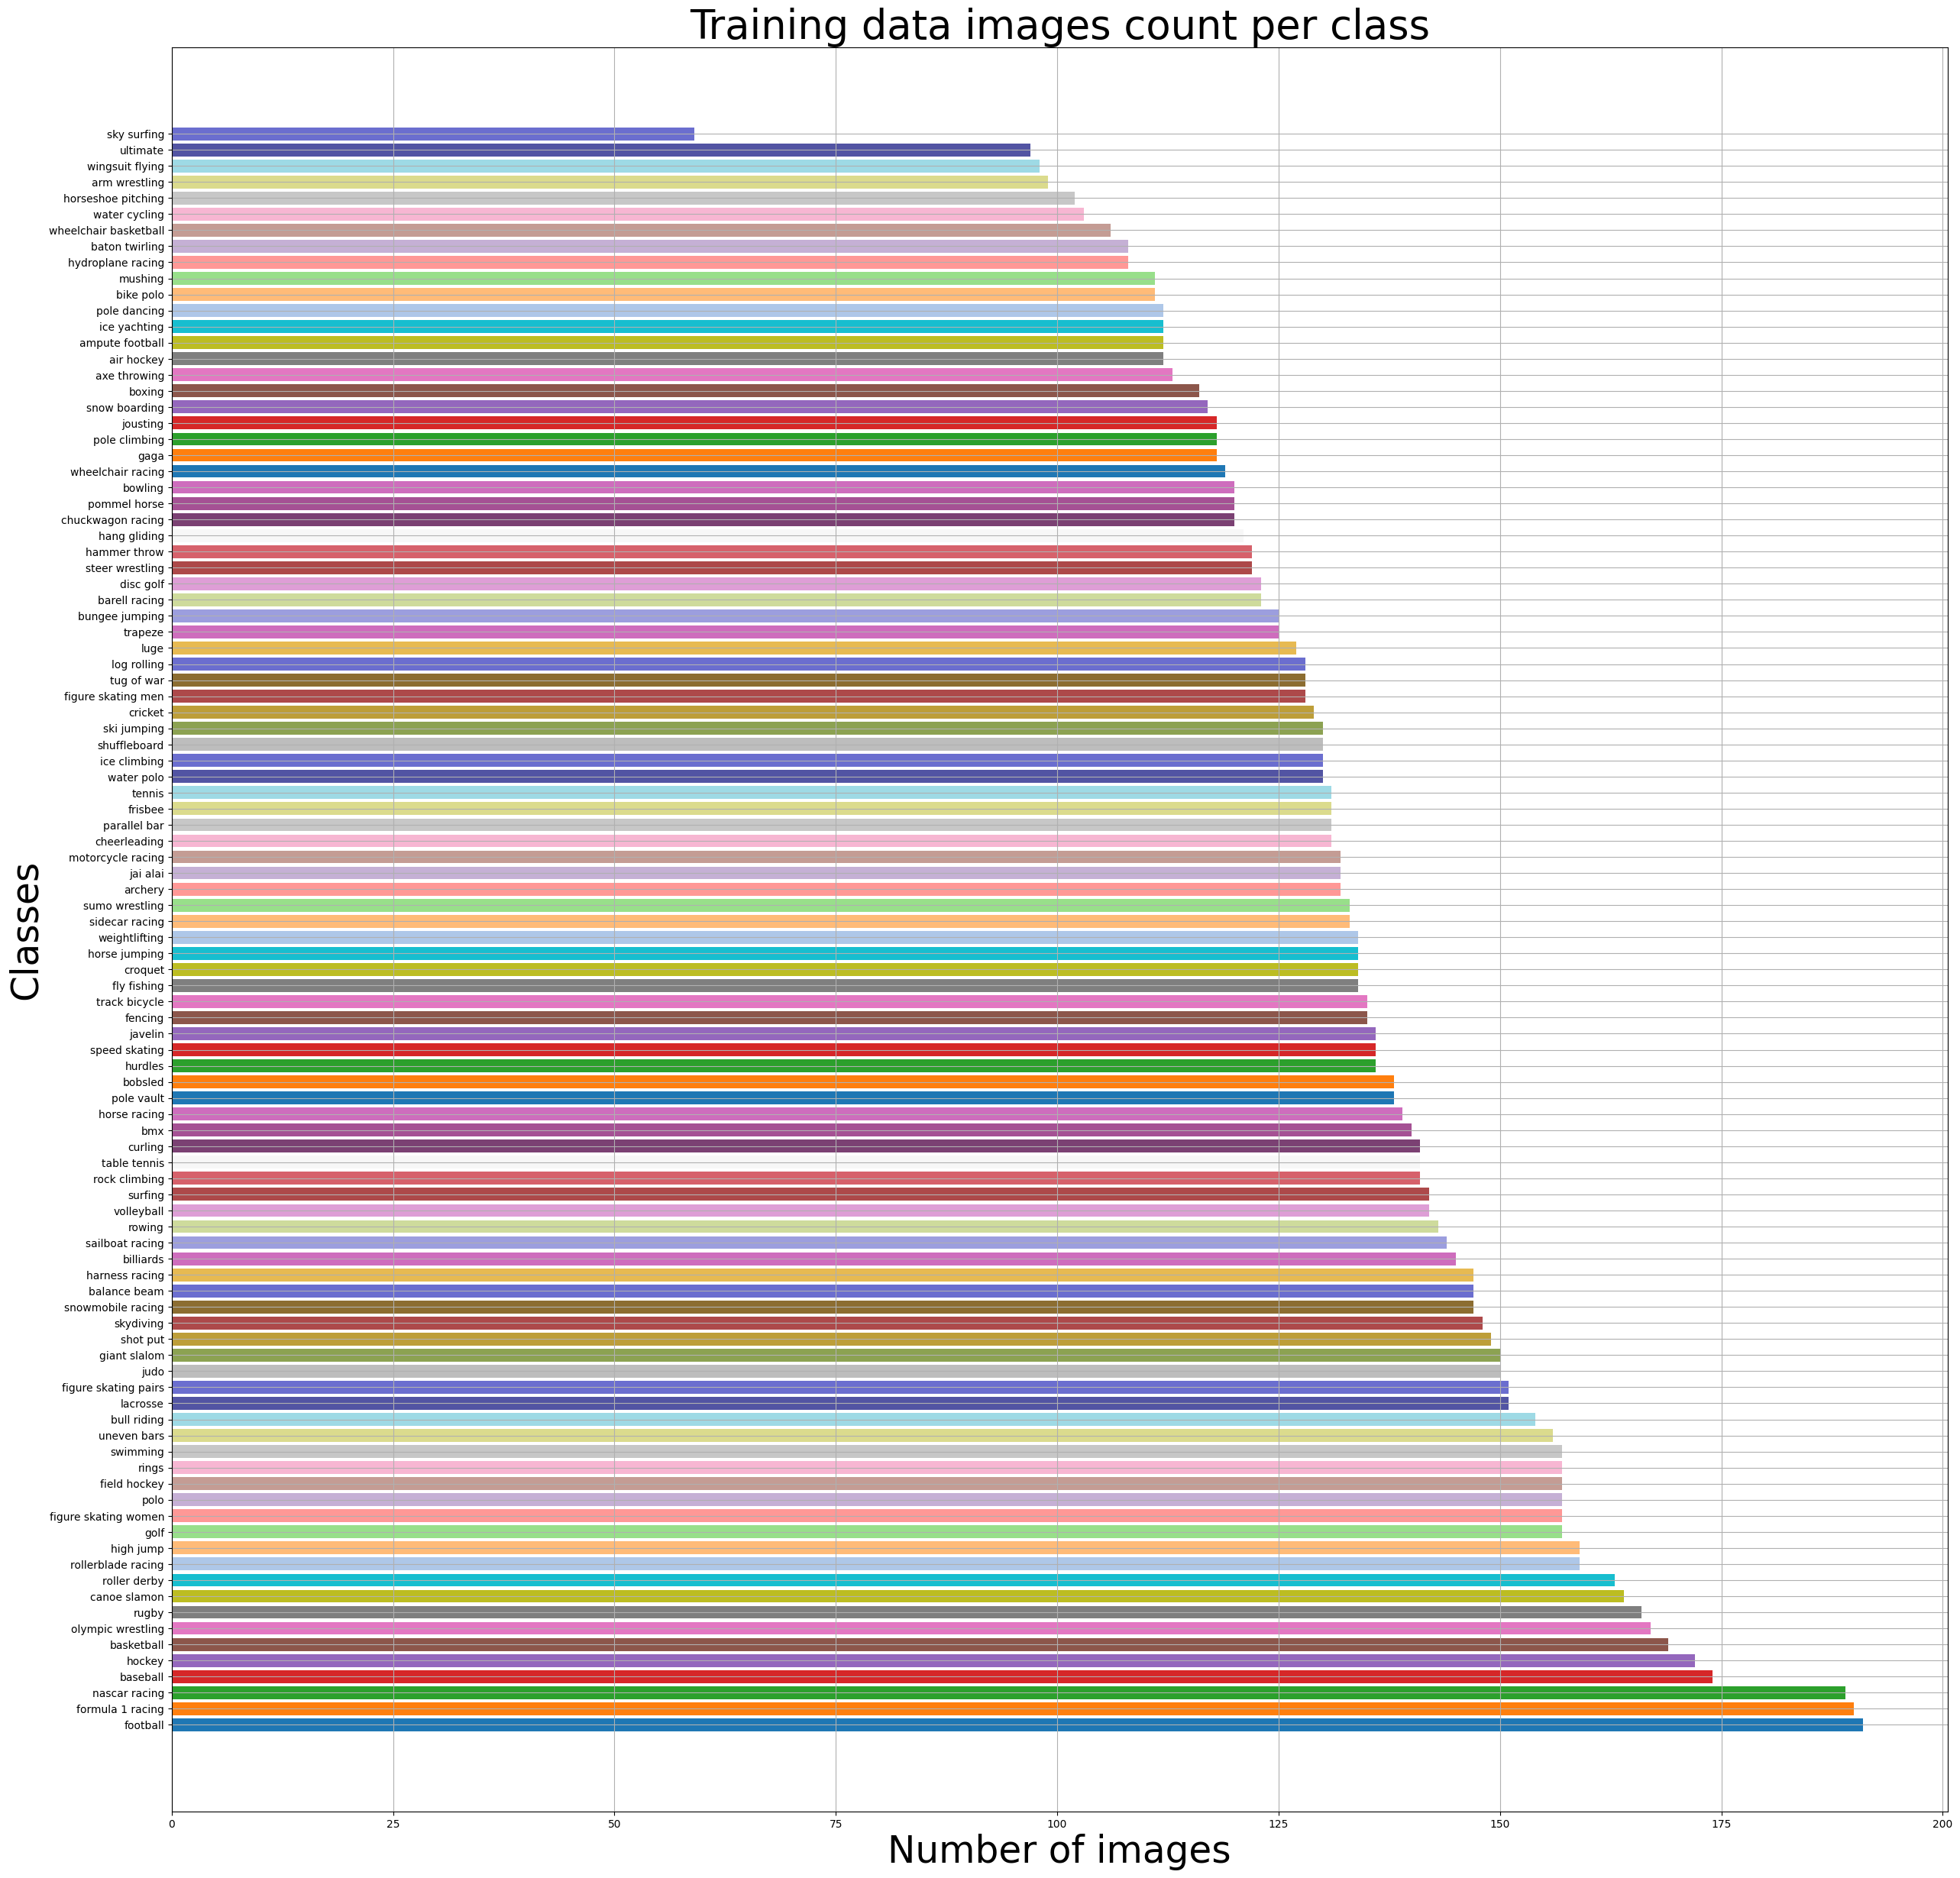

In [4]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(30,30))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()


In [5]:
train_df.sample(n=15, random_state=1)

imgpath  \
1049   /content/drive/MyDrive/Original data/data orig...   
9190   /content/drive/MyDrive/Original data/data orig...   
335    /content/drive/MyDrive/Original data/data orig...   
7970   /content/drive/MyDrive/Original data/data orig...   
10606  /content/drive/MyDrive/Original data/data orig...   
12844  /content/drive/MyDrive/Original data/data orig...   
6835   /content/drive/MyDrive/Original data/data orig...   
5988   /content/drive/MyDrive/Original data/data orig...   
5045   /content/drive/MyDrive/Original data/data orig...   
8908   /content/drive/MyDrive/Original data/data orig...   
35     /content/drive/MyDrive/Original data/data orig...   
4852   /content/drive/MyDrive/Original data/data orig...   
3576   /content/drive/MyDrive/Original data/data orig...   
5707   /content/drive/MyDrive/Original data/data orig...   
5680   /content/drive/MyDrive/Original data/data orig...   

                      labels  encoded_labels  
1049              volleyball              93  
9190                football              31  
335        wheelchair racing              98  
7970                jai alai              49  
10606   figure skating pairs              28  
12844             basketball               8  
6835           horse jumping              42  
5988           nascar racing              58  
5045      rollerblade racing              69  
8908        formula 1 racing              32  
35     wheelchair basketball              97  
4852                    polo              64  
3576                shot put              73  
5707                 javelin              50  
5680                jousting              51

In [6]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath                 labels
0  /content/drive/MyDrive/Original data/data orig...  wheelchair basketball
1  /content/drive/MyDrive/Original data/data orig...  wheelchair basketball
2  /content/drive/MyDrive/Original data/data orig...  wheelchair basketball
3  /content/drive/MyDrive/Original data/data orig...  wheelchair basketball
4  /content/drive/MyDrive/Original data/data orig...  wheelchair basketball
(13499, 3)
--------Validation----------
                                             imgpath      labels
0  /content/drive/MyDrive/Original data/data orig...  volleyball
1  /content/drive/MyDrive/Original data/data orig...  volleyball
2  /content/drive/MyDrive/Original data/data orig...  volleyball
3  /content/drive/MyDrive/Original data/data orig...  volleyball
4  /content/drive/MyDrive/Original data/data orig...  volleyball
(500, 3)
----------Test--------------
                                             im

Show sample from data

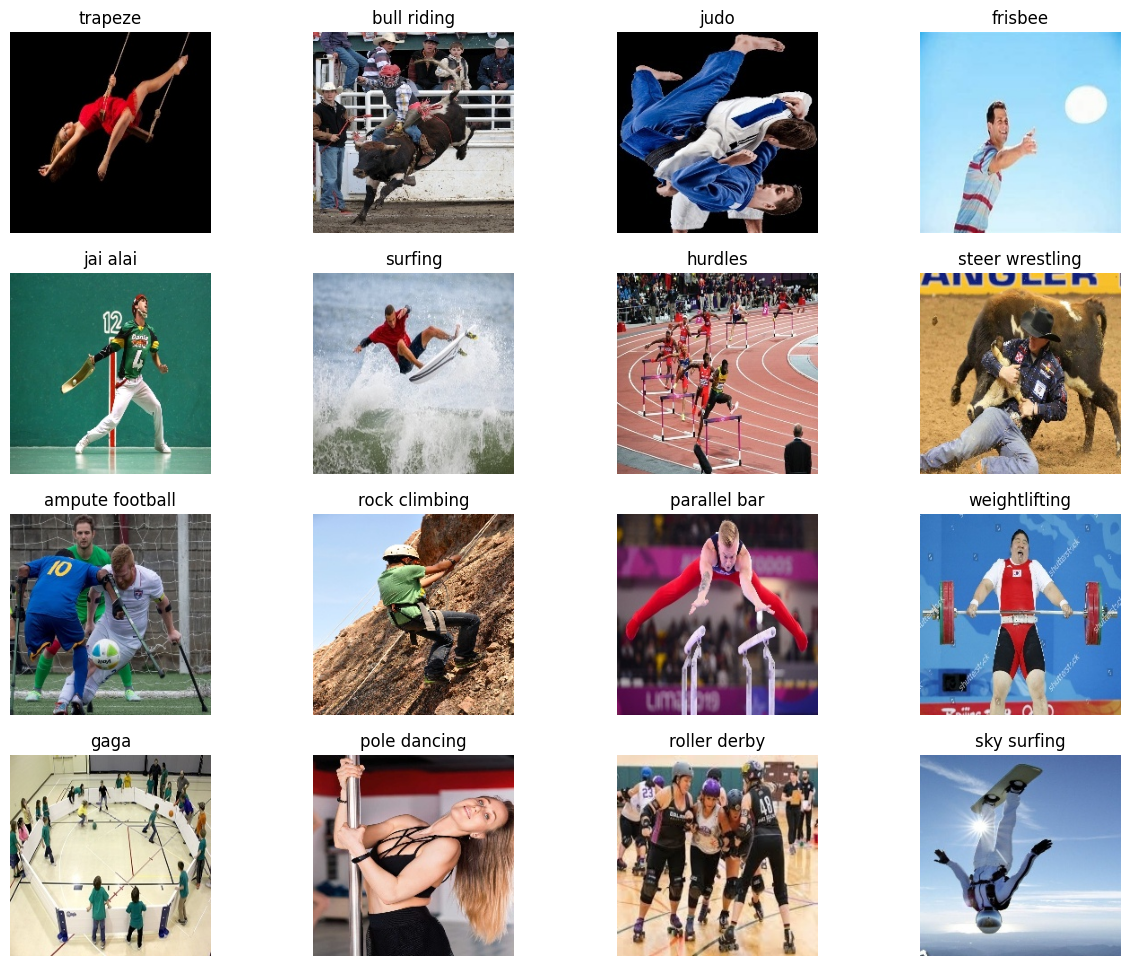

In [7]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

#EfficientNet B0

In [8]:
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 13498 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


In [9]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [10]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(350)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 350)               448350    
                                                                 
 activation (Activation)     (None, 350)               0         
                                                                 
 batch_normalization (Batch  (None, 350)               1400  

Training: Transfer learning

In [11]:
import time
start_time = time.time()

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save('/content/drive/MyDrive/Original data/data original/EfficientNetB0_original.h5')

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/50
1350/1350 [==============================] - 5379s 4s/step - loss: 1.7868 - accuracy: 0.5797 - val_loss: 0.5384 - val_accuracy: 0.8480 - lr: 5.0000e-04
Epoch 2/50
1350/1350 [==============================] - 47s 35ms/step - loss: 0.8170 - accuracy: 0.7863 - val_loss: 0.4080 - val_accuracy: 0.8700 - lr: 5.0000e-04
Epoch 3/50
1350/1350 [==============================] - 46s 34ms/step - loss: 0.6555 - accuracy: 0.8255 - val_loss: 0.3643 - val_accuracy: 0.8960 - lr: 5.0000e-04
Epoch 4/50
1350/1350 [==============================] - 46s 34ms/step - loss: 0.6031 - accuracy: 0.8346 - val_loss: 0.2897 - val_accuracy: 0.9360 - lr: 5.0000e-04
Epoch 5/50
1350/1350 [==============================] - 45s 34ms/step - loss: 0.5462 - accuracy: 0.8487 - val_loss: 0.3114 - val_accuracy: 0.9020 - lr: 5.0000e-04
Epoch 6/50
1350/1350 [==============================] - 46s 34ms/step - loss: 0.5178 - accuracy: 0.8548 - val_loss: 0.2990 - val_accuracy: 0.9300 - lr: 5.0000e-04
Epoch 7/50
1350/1350 [

Display model performance

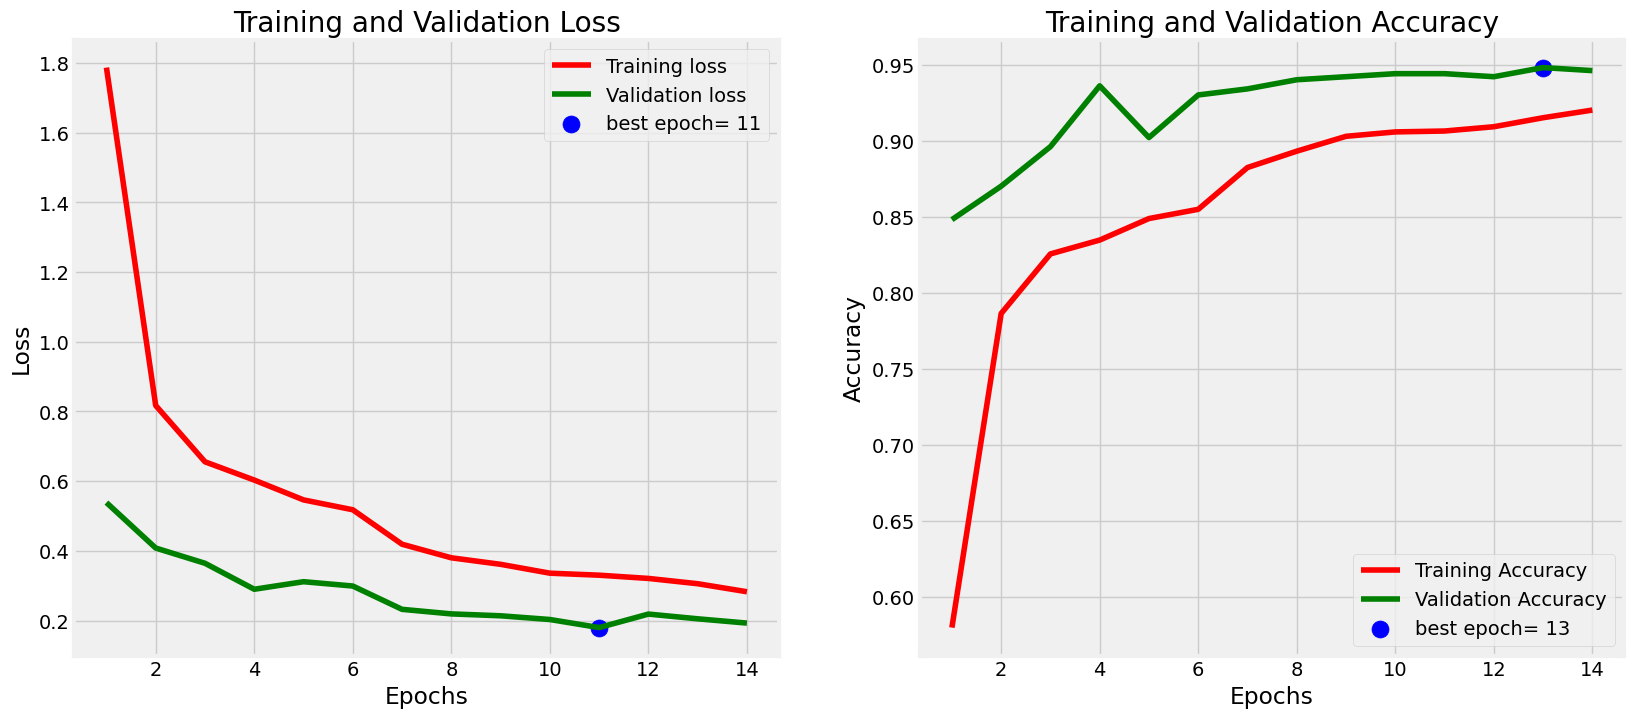

In [12]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


Model Evaluate

In [13]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.12266
Test Accuracy: 96.40%


F1 Score / Recall / Precision

In [14]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

50/50 [==============================] - 3s 30ms/step
F1 Score: 0.9627399267399268
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       0.83      1.00      0.91         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       0.71      1.00      0.83         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      0.80      0.89         5
           basketball       0.83      1.00      0.91         5
       baton twirling       1.00      0.80      0.89         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      1.00      1.00         5
              bobsled       0.80  

In [15]:
# predict labels on EfficientNetB0 test_set
preds = model.predict(test_images)
y_pred = np.argmax(preds, axis=1)
true_classes = test_images.classes
class_labels = list(test_images.class_indices.keys())  # Class names

# Confusion Matrix
cm = confusion_matrix(true_classes, y_pred)

# Calculating the accuracy for each class
accuracies = cm.diagonal() / cm.sum(axis=1)

# Displaying class-specific accuracies
for class_label, accuracy in zip(class_labels, accuracies):
    print(f"{class_label}: {accuracy:.2%}")

50/50 [==============================] - 2s 31ms/step
air hockey: 100.00%
ampute football: 100.00%
archery: 100.00%
arm wrestling: 100.00%
axe throwing: 100.00%
balance beam: 100.00%
barell racing: 100.00%
baseball: 80.00%
basketball: 100.00%
baton twirling: 80.00%
bike polo: 100.00%
billiards: 100.00%
bmx: 100.00%
bobsled: 80.00%
bowling: 80.00%
boxing: 100.00%
bull riding: 100.00%
bungee jumping: 100.00%
canoe slamon: 100.00%
cheerleading: 80.00%
chuckwagon racing: 100.00%
cricket: 100.00%
croquet: 100.00%
curling: 100.00%
disc golf: 100.00%
fencing: 100.00%
field hockey: 100.00%
figure skating men: 100.00%
figure skating pairs: 40.00%
figure skating women: 100.00%
fly fishing: 100.00%
football: 100.00%
formula 1 racing: 100.00%
frisbee: 80.00%
gaga: 100.00%
giant slalom: 100.00%
golf: 100.00%
hammer throw: 100.00%
hang gliding: 100.00%
harness racing: 100.00%
high jump: 100.00%
hockey: 100.00%
horse jumping: 100.00%
horse racing: 100.00%
horseshoe pitching: 100.00%
hurdles: 100.00%


In [16]:
# Get Prediction
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

50/50 [==============================] - 2s 30ms/step


Image Index  Test Labels           Test Classes  Prediction Labels  \
0            0           99        wingsuit flying                 99   
1            1           99        wingsuit flying                 99   
2            2           99        wingsuit flying                 99   
3            3           99        wingsuit flying                 99   
4            4           99        wingsuit flying                 99   
5            5           97  wheelchair basketball                 97   
6            6           97  wheelchair basketball                 97   
7            7           97  wheelchair basketball                 97   

      Prediction Classes                                               Path  \
0        wingsuit flying  /content/drive/MyDrive/Original data/data orig...   
1        wingsuit flying  /content/drive/MyDrive/Original data/data orig...   
2        wingsuit flying  /content/drive/MyDrive/Original data/data orig...   
3        wingsuit flying  /content/drive/MyDrive/Original data/data orig...   
4        wingsuit flying  /content/drive/MyDrive/Original data/data orig...   
5  wheelchair basketball  /content/drive/MyDrive/Original data/data orig...   
6  wheelchair basketball  /content/drive/MyDrive/Original data/data orig...   
7  wheelchair basketball  /content/drive/MyDrive/Original data/data orig...   

   Prediction Probability  
0                0.999400  
1                0.752182  
2                0.884827  
3                0.998957  
4                0.854929  
5                0.999768  
6                0.999992  
7                0.999777

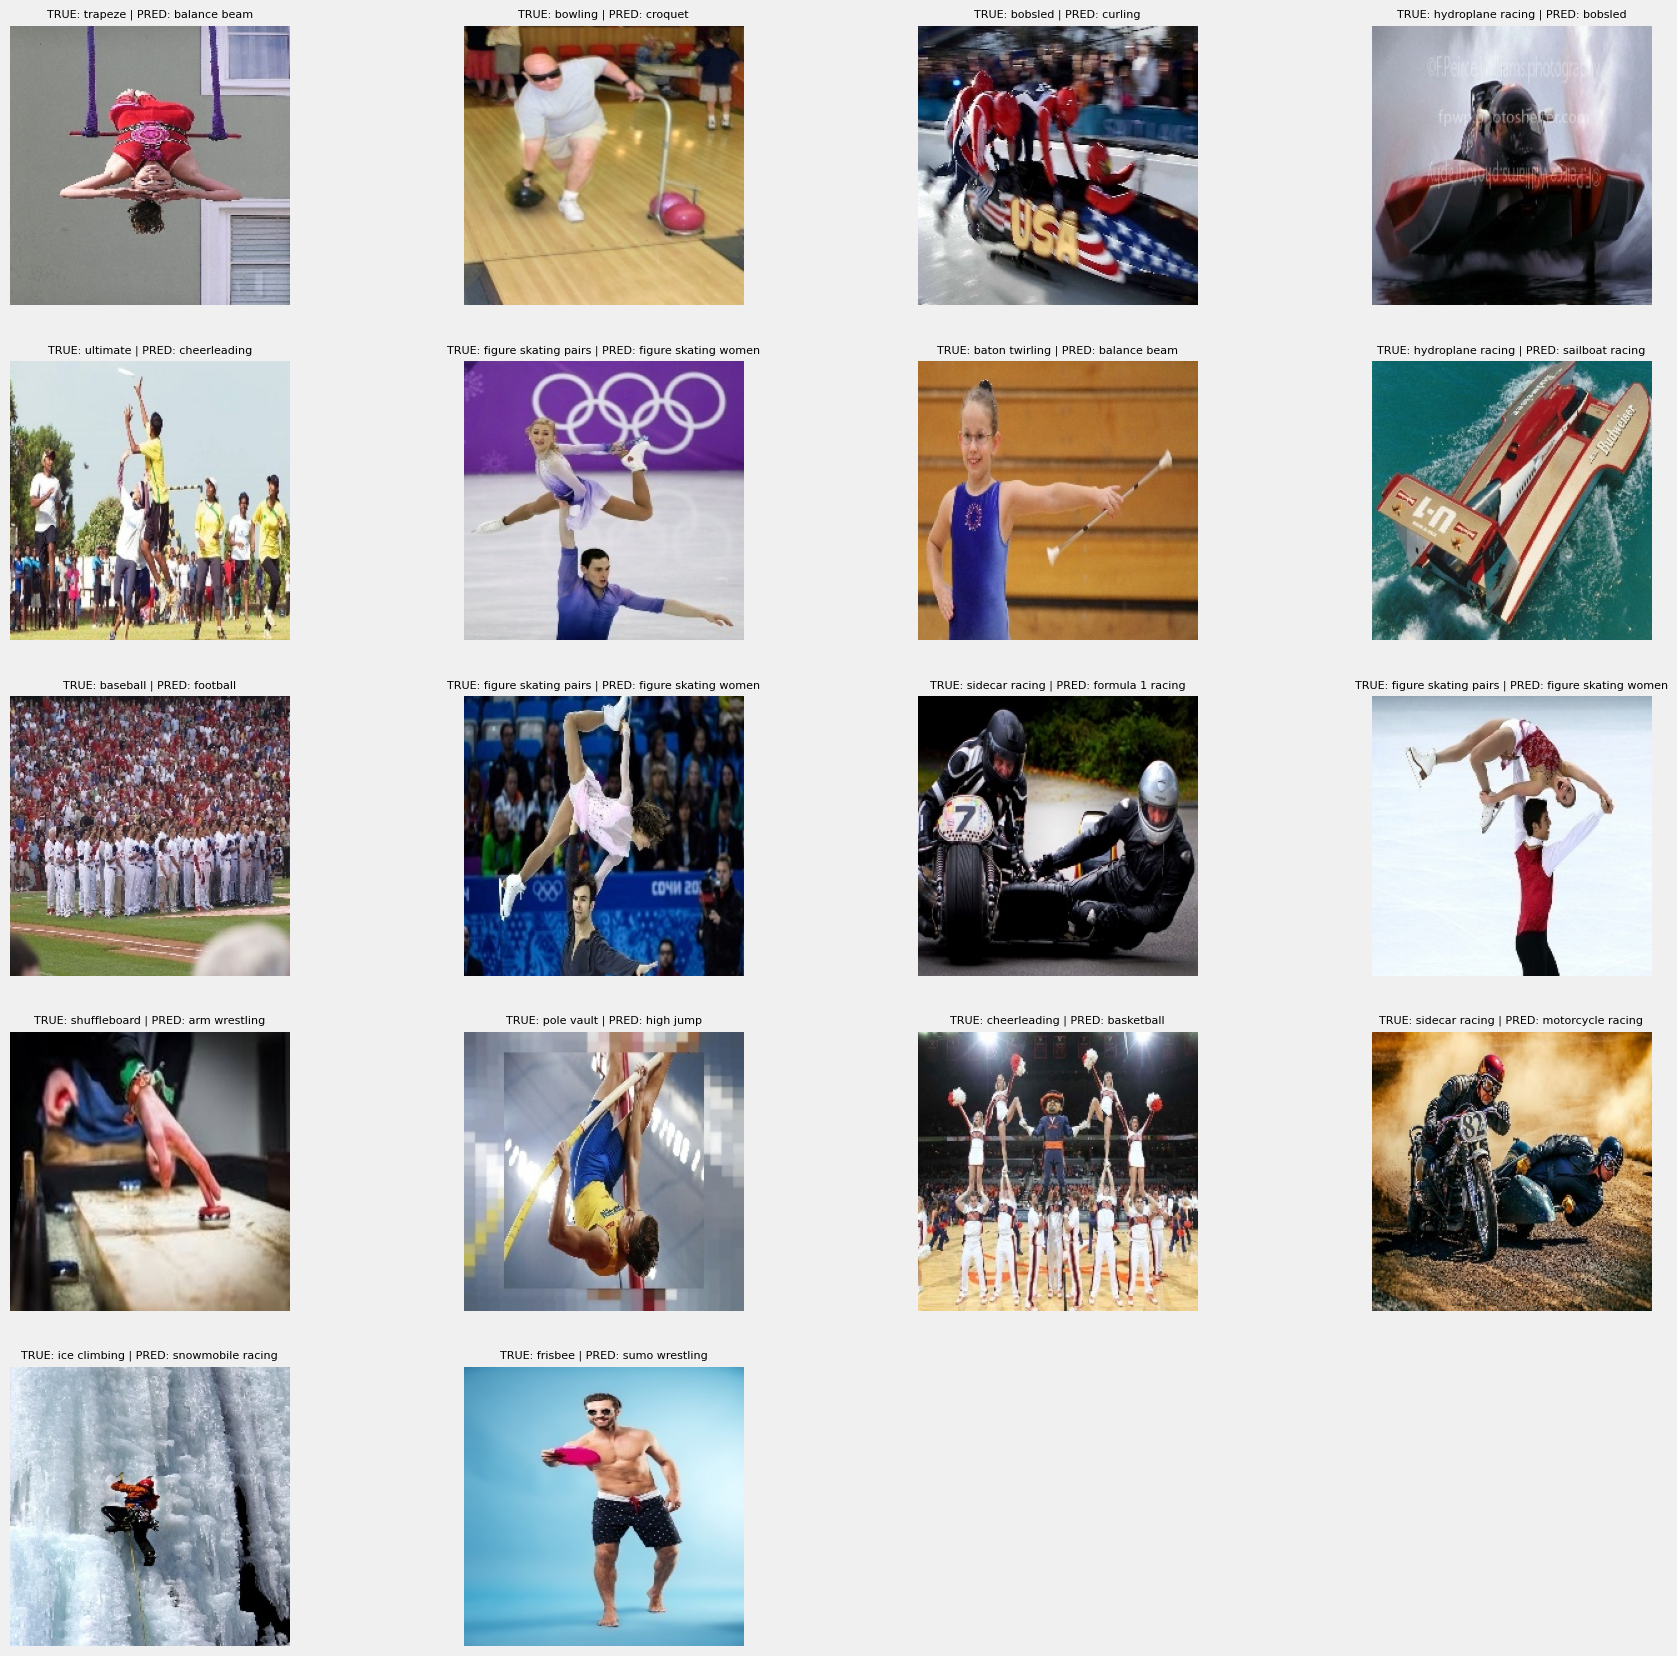

In [17]:
# Print the most confident errors
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

#VGG19

In [18]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.vgg19.preprocess_input)
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_vgg19 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_vgg19 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_vgg19 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 13498 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


In [19]:
from keras.applications import VGG19
# Load and modify the VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

80134624/80134624 [==============================] - 1s 0us/step


In [20]:
from keras.layers import GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom, RandomContrast
num_classes = len(set(train_images_vgg19.classes))
# Define data augmentation
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1),
  RandomZoom(0.1),
  RandomContrast(0.1),
], name='data_augmentation')

# Modify the model
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)  # Set training=False for batch norm layers
x = GlobalAveragePooling2D()(x)
x = Dense(350, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 350)               179550    
                                                                 
 batch_normalization_1 (Bat  (None, 350)               1400

Training: Transfer learning

In [21]:
import time
start_time = time.time()

# Train the model
history_vgg19 = model.fit(
    train_images_vgg19,
    steps_per_epoch=len(train_images_vgg19),
    validation_data=val_images_vgg19,
    validation_steps=len(val_images_vgg19),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

# Save the model
model.save('/content/drive/MyDrive/Original data/data original/VGG19_original.h5')

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/50
1350/1350 [==============================] - 57s 40ms/step - loss: 2.7512 - accuracy: 0.3445 - val_loss: 1.6625 - val_accuracy: 0.6560 - lr: 5.0000e-04
Epoch 2/50
1350/1350 [==============================] - 53s 39ms/step - loss: 1.6859 - accuracy: 0.5613 - val_loss: 1.3140 - val_accuracy: 0.7080 - lr: 5.0000e-04
Epoch 3/50
1350/1350 [==============================] - 52s 39ms/step - loss: 1.4305 - accuracy: 0.6176 - val_loss: 1.0888 - val_accuracy: 0.7620 - lr: 5.0000e-04
Epoch 4/50
1350/1350 [==============================] - 51s 38ms/step - loss: 1.3159 - accuracy: 0.6462 - val_loss: 1.0718 - val_accuracy: 0.7640 - lr: 5.0000e-04
Epoch 5/50
1350/1350 [==============================] - 53s 39ms/step - loss: 1.2343 - accuracy: 0.6642 - val_loss: 1.1606 - val_accuracy: 0.7480 - lr: 5.0000e-04
Epoch 6/50
1350/1350 [==============================] - 52s 39ms/step - loss: 1.1724 - accuracy: 0.6829 - val_loss: 1.1326 - val_accuracy: 0.7660 - lr: 5.0000e-04
Epoch 7/50
1350/1350 [

Display model performance

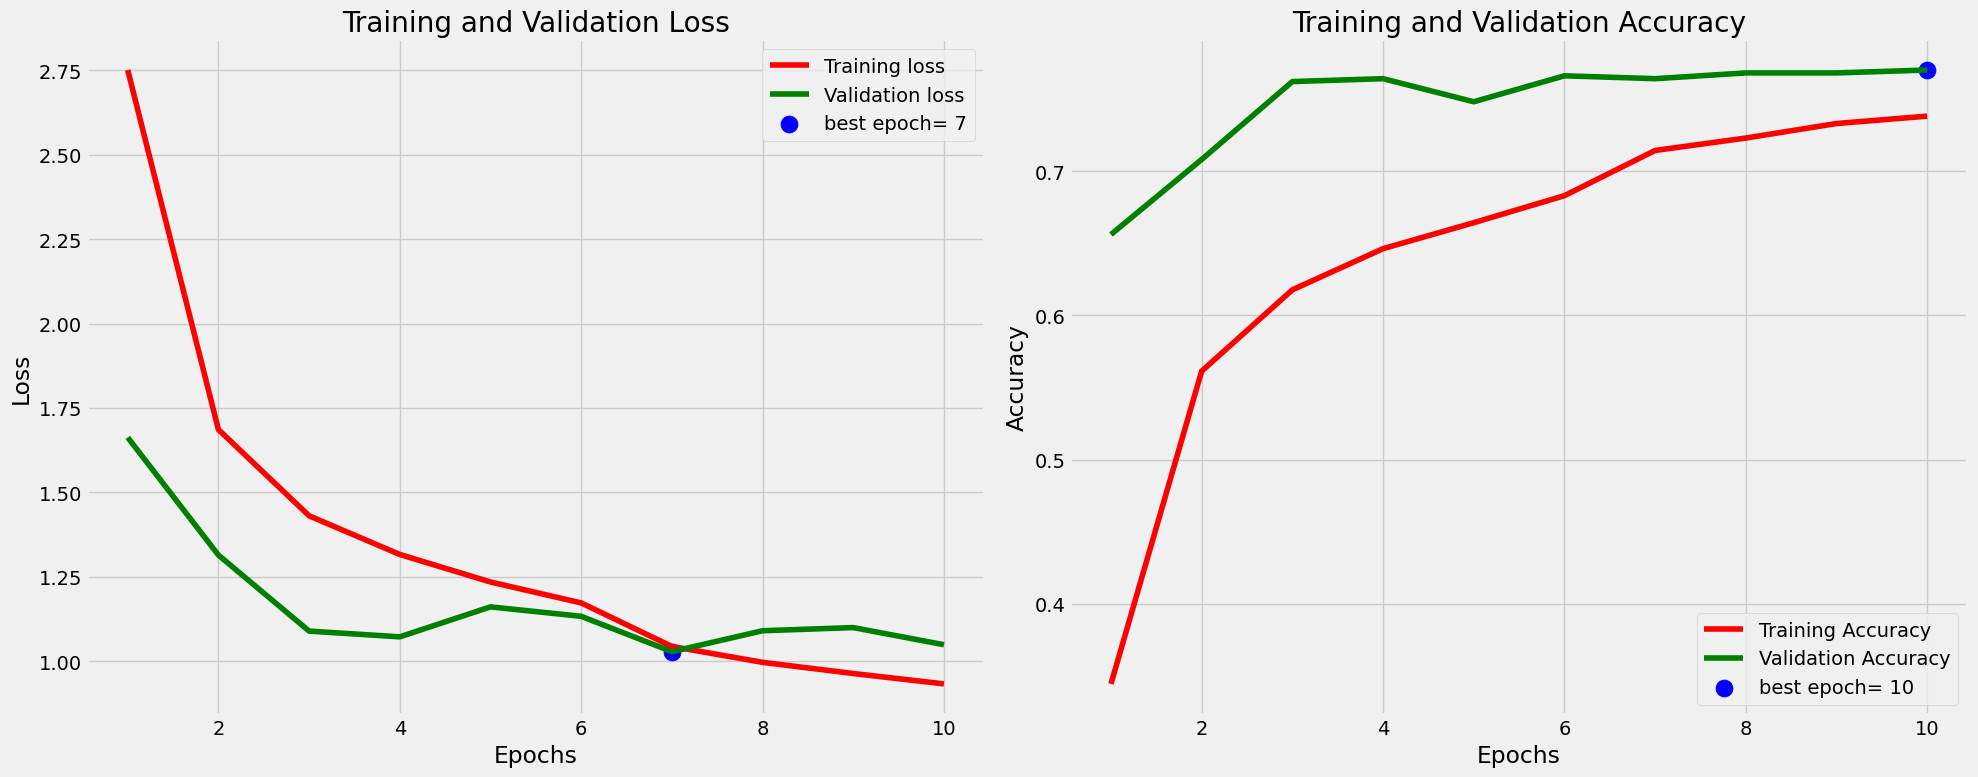

In [22]:
# Corrected variable assignments
tr_acc = history_vgg19.history['accuracy']
tr_loss = history_vgg19.history['loss']
val_acc = history_vgg19.history['val_accuracy']
val_loss = history_vgg19.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

model evaluate

In [23]:
results = model.evaluate(test_images_vgg19, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.70806
Test Accuracy: 84.00%


F1 Score / Recall / Precision

In [24]:
y_true = test_images_vgg19.classes
y_pred = np.argmax(model.predict(test_images_vgg19), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_vgg19.class_indices.keys()))

50/50 [==============================] - 2s 35ms/step
F1 Score: 0.83780766292531
                       precision    recall  f1-score   support

           air hockey       0.83      1.00      0.91         5
      ampute football       0.83      1.00      0.91         5
              archery       0.71      1.00      0.83         5
        arm wrestling       1.00      0.80      0.89         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       0.80      0.80      0.80         5
        barell racing       0.71      1.00      0.83         5
             baseball       0.60      0.60      0.60         5
           basketball       1.00      0.40      0.57         5
       baton twirling       1.00      0.60      0.75         5
            bike polo       1.00      1.00      1.00         5
            billiards       0.83      1.00      0.91         5
                  bmx       1.00      0.80      0.89         5
              bobsled       1.00    

In [25]:
# predict labels on vgg19 test_set
preds = model.predict(test_images_vgg19)
y_pred = np.argmax(preds, axis=1)
true_classes = test_images_vgg19.classes
class_labels = list(test_images_vgg19.class_indices.keys())  # Class names

# Confusion Matrix
cm = confusion_matrix(true_classes, y_pred)

# Calculating the accuracy for each class
accuracies = cm.diagonal() / cm.sum(axis=1)

# Displaying class-specific accuracies
for class_label, accuracy in zip(class_labels, accuracies):
    print(f"{class_label}: {accuracy:.2%}")

50/50 [==============================] - 2s 36ms/step
air hockey: 100.00%
ampute football: 100.00%
archery: 100.00%
arm wrestling: 80.00%
axe throwing: 100.00%
balance beam: 80.00%
barell racing: 100.00%
baseball: 60.00%
basketball: 40.00%
baton twirling: 60.00%
bike polo: 100.00%
billiards: 100.00%
bmx: 80.00%
bobsled: 60.00%
bowling: 80.00%
boxing: 80.00%
bull riding: 100.00%
bungee jumping: 100.00%
canoe slamon: 80.00%
cheerleading: 60.00%
chuckwagon racing: 80.00%
cricket: 80.00%
croquet: 100.00%
curling: 100.00%
disc golf: 100.00%
fencing: 100.00%
field hockey: 40.00%
figure skating men: 100.00%
figure skating pairs: 60.00%
figure skating women: 80.00%
fly fishing: 100.00%
football: 100.00%
formula 1 racing: 100.00%
frisbee: 80.00%
gaga: 80.00%
giant slalom: 100.00%
golf: 80.00%
hammer throw: 80.00%
hang gliding: 100.00%
harness racing: 100.00%
high jump: 100.00%
hockey: 100.00%
horse jumping: 100.00%
horse racing: 60.00%
horseshoe pitching: 60.00%
hurdles: 80.00%
hydroplane racin

#ResNet50

In [26]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.resnet50.preprocess_input)
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_resnet50 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_resnet50 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_resnet50 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 13498 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


In [27]:
from keras.applications import ResNet50
pretrained_model_resnet50 = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

94765736/94765736 [==============================] - 1s 0us/step


In [28]:
num_classes = len(set(train_images_resnet50.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Load pre-trained ResNet50 model
pretrained_model_resnet50 = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of the pretrained neural network
for layer in pretrained_model_resnet50.layers:
    layer.trainable = False

inputs_resnet50 = layers.Input(shape=(224, 224, 3), name='inputLayer')
x_resnet50 = augment(inputs_resnet50)
pretrain_out_resnet50 = pretrained_model_resnet50(x_resnet50, training=False)
x_resnet50 = layers.Dense(350, activation="relu")(pretrain_out_resnet50)
x_resnet50 = layers.BatchNormalization()(x_resnet50)
x_resnet50 = layers.Dropout(0.25)(x_resnet50)
x_resnet50 = layers.Dense(num_classes, activation='softmax', dtype=tf.float32, name='activationLayer')(x_resnet50)

model_resnet50 = Model(inputs=inputs_resnet50, outputs=x_resnet50)

model_resnet50.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model_resnet50.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 350)               717150    
                                                                 
 batch_normalization_2 (Bat  (None, 350)               1400      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 350)               0   

Transfer learning

In [29]:
import time
start_time = time.time()

history_resnet50 = model_resnet50.fit(
    train_images_resnet50,
    steps_per_epoch=len(train_images_resnet50),
    validation_data=val_images_resnet50,
    validation_steps=len(val_images_resnet50),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model_resnet50.save('/content/drive/MyDrive/Original data/data original/ResNet50_original.h5')

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/50
1350/1350 [==============================] - 59s 40ms/step - loss: 2.3152 - accuracy: 0.4529 - val_loss: 0.8038 - val_accuracy: 0.7800 - lr: 5.0000e-04
Epoch 2/50
1350/1350 [==============================] - 54s 40ms/step - loss: 1.3282 - accuracy: 0.6651 - val_loss: 0.6360 - val_accuracy: 0.8180 - lr: 5.0000e-04
Epoch 3/50
1350/1350 [==============================] - 53s 39ms/step - loss: 1.0978 - accuracy: 0.7123 - val_loss: 0.6107 - val_accuracy: 0.8160 - lr: 5.0000e-04
Epoch 4/50
1350/1350 [==============================] - 52s 39ms/step - loss: 1.0048 - accuracy: 0.7290 - val_loss: 0.6141 - val_accuracy: 0.8140 - lr: 5.0000e-04
Epoch 5/50
1350/1350 [==============================] - 54s 40ms/step - loss: 0.9276 - accuracy: 0.7464 - val_loss: 0.5101 - val_accuracy: 0.8520 - lr: 5.0000e-04
Epoch 6/50
1350/1350 [==============================] - 53s 39ms/step - loss: 0.8893 - accuracy: 0.7547 - val_loss: 0.5553 - val_accuracy: 0.8220 - lr: 5.0000e-04
Epoch 7/50
1350/1350 [

Display model performance

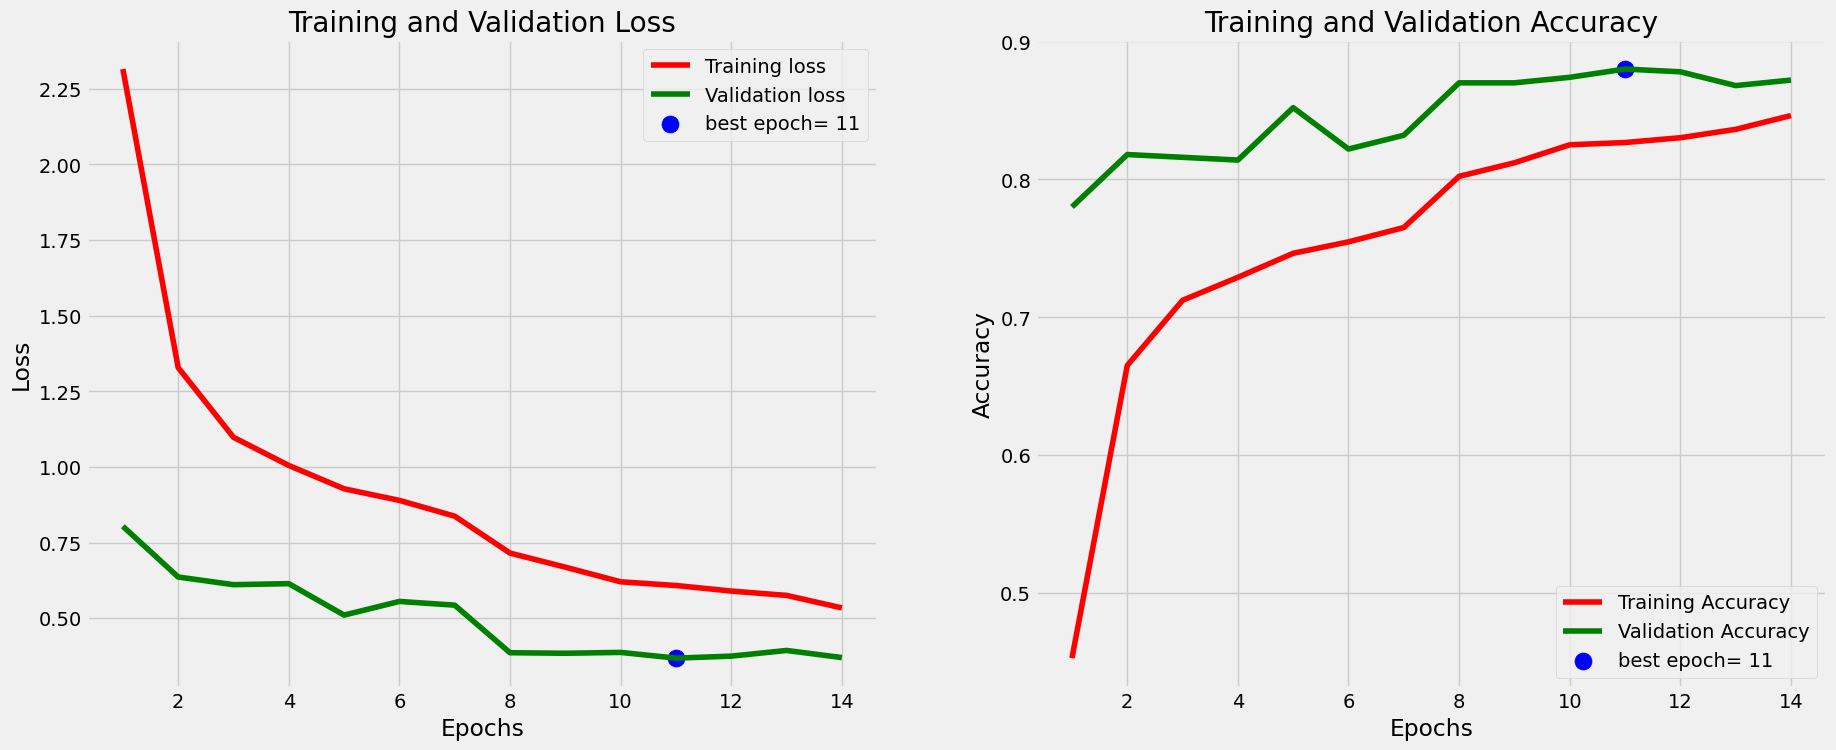

In [30]:
# Define needed variables
tr_acc = history_resnet50.history['accuracy']
tr_loss = history_resnet50.history['loss']
val_acc = history_resnet50.history['val_accuracy']
val_loss = history_resnet50.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

  model evaluate

In [31]:
results_resnet50 = model_resnet50.evaluate(test_images_resnet50, verbose=0)
print("ResNet50 Model - Test Loss: {:.5f}".format(results_resnet50[0]))
print("ResNet50 Model - Test Accuracy: {:.2f}%".format(results_resnet50[1] * 100))

ResNet50 Model - Test Loss: 0.32444
ResNet50 Model - Test Accuracy: 90.00%


F1 Score / Recall / Precision

In [32]:
y_true = test_images_resnet50.classes
y_pred = np.argmax(model_resnet50.predict(test_images_resnet50), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_resnet50.class_indices.keys()))

50/50 [==============================] - 3s 36ms/step
F1 Score: 0.8953900543900544
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       0.80      0.80      0.80         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       0.71      1.00      0.83         5
         balance beam       0.71      1.00      0.83         5
        barell racing       0.83      1.00      0.91         5
             baseball       1.00      0.60      0.75         5
           basketball       0.83      1.00      0.91         5
       baton twirling       1.00      0.80      0.89         5
            bike polo       1.00      0.80      0.89         5
            billiards       0.83      1.00      0.91         5
                  bmx       1.00      0.40      0.57         5
              bobsled       0.75  

In [33]:
#predict labels on resnet50 test_set
preds =  model_resnet50.predict(test_images_resnet50)
y_pred = np.argmax(preds, axis=1)
true_classes = test_images_resnet50.classes
class_labels = list(test_images_resnet50.class_indices.keys())  # Class names

# Confusion Matrix
cm = confusion_matrix(true_classes, y_pred)

# Calculating the accuracy for each class
accuracies = cm.diagonal() / cm.sum(axis=1)

# Displaying class-specific accuracies
for class_label, accuracy in zip(class_labels, accuracies):
    print(f"{class_label}: {accuracy:.2%}")

50/50 [==============================] - 2s 36ms/step
air hockey: 100.00%
ampute football: 100.00%
archery: 80.00%
arm wrestling: 100.00%
axe throwing: 100.00%
balance beam: 100.00%
barell racing: 100.00%
baseball: 60.00%
basketball: 100.00%
baton twirling: 80.00%
bike polo: 80.00%
billiards: 100.00%
bmx: 40.00%
bobsled: 60.00%
bowling: 100.00%
boxing: 100.00%
bull riding: 80.00%
bungee jumping: 60.00%
canoe slamon: 100.00%
cheerleading: 80.00%
chuckwagon racing: 100.00%
cricket: 100.00%
croquet: 100.00%
curling: 100.00%
disc golf: 100.00%
fencing: 80.00%
field hockey: 60.00%
figure skating men: 100.00%
figure skating pairs: 60.00%
figure skating women: 100.00%
fly fishing: 100.00%
football: 100.00%
formula 1 racing: 100.00%
frisbee: 80.00%
gaga: 100.00%
giant slalom: 100.00%
golf: 100.00%
hammer throw: 100.00%
hang gliding: 100.00%
harness racing: 100.00%
high jump: 100.00%
hockey: 80.00%
horse jumping: 100.00%
horse racing: 80.00%
horseshoe pitching: 80.00%
hurdles: 100.00%
hydroplan

#MobileNet V3 Large

In [34]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input)

BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_mobilenet = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_mobilenet = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_mobilenet = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 13498 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


In [35]:
from keras.applications import MobileNetV3Large

pretrained_model_mobilenetv3 = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of the pretrained neural network
for layer in pretrained_model_mobilenetv3.layers:
    layer.trainable = False

12683000/12683000 [==============================] - 0s 0us/step


In [36]:
from keras.layers import GlobalAveragePooling2D
num_classes = len(set(train_images_mobilenet.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Building the model
inputs = layers.Input(shape=(224, 224, 3), name='inputLayer')
x = augment(inputs)
x = pretrained_model_mobilenetv3(x, training=False)
x = layers.Dense(350, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 MobilenetV3large (Function  (None, 960)               2996352   
 al)                                                             
                                                                 
 dense_5 (Dense)             (None, 350)               336350    
                                                                 
 batch_normalization_3 (Bat  (None, 350)               1400      
 chNormalization)                                                
                                                           

Transfer learning

In [37]:
import time
start_time = time.time()

# Training the model
history = model.fit(
    train_images_mobilenet,
    steps_per_epoch=len(train_images_mobilenet),
    validation_data=val_images_mobilenet,
    validation_steps=len(val_images_mobilenet),
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

# Save the model
model.save('/content/drive/MyDrive/Original data/data original/MobileNetV3_Large_original.h5')

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/50
1350/1350 [==============================] - 52s 35ms/step - loss: 1.9182 - accuracy: 0.5367 - val_loss: 0.6348 - val_accuracy: 0.8300 - lr: 5.0000e-04
Epoch 2/50
1350/1350 [==============================] - 46s 34ms/step - loss: 0.8606 - accuracy: 0.7697 - val_loss: 0.3817 - val_accuracy: 0.8860 - lr: 5.0000e-04
Epoch 3/50
1350/1350 [==============================] - 45s 34ms/step - loss: 0.6800 - accuracy: 0.8117 - val_loss: 0.4529 - val_accuracy: 0.8960 - lr: 5.0000e-04
Epoch 4/50
1350/1350 [==============================] - 45s 34ms/step - loss: 0.6052 - accuracy: 0.8303 - val_loss: 0.3618 - val_accuracy: 0.9080 - lr: 5.0000e-04
Epoch 5/50
1350/1350 [==============================] - 45s 34ms/step - loss: 0.5408 - accuracy: 0.8431 - val_loss: 0.3875 - val_accuracy: 0.9060 - lr: 5.0000e-04
Epoch 6/50
1350/1350 [==============================] - 46s 34ms/step - loss: 0.5086 - accuracy: 0.8533 - val_loss: 0.2976 - val_accuracy: 0.9060 - lr: 5.0000e-04
Epoch 7/50
1350/1350 [

Display model performance

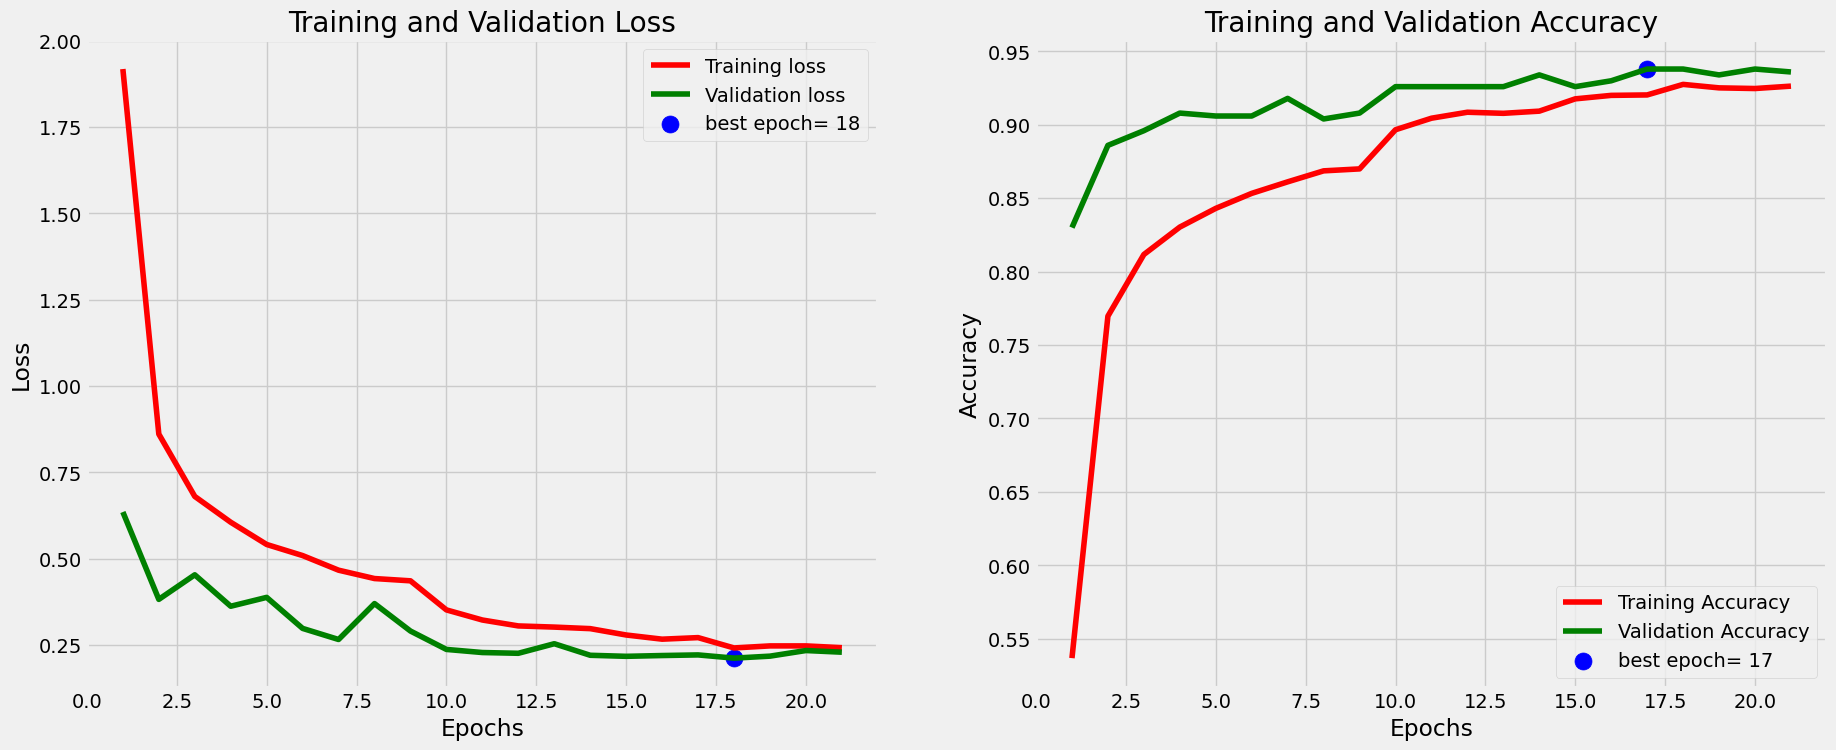

In [38]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

model evaluate

In [39]:
results_mobilenet = model.evaluate(test_images_mobilenet, verbose=0)
print("MobileNet Model - Test Loss: {:.5f}".format(results_mobilenet[0]))
print("MobileNet Model - Test Accuracy: {:.2f}%".format(results_mobilenet[1] * 100))

MobileNet Model - Test Loss: 0.14620
MobileNet Model - Test Accuracy: 97.00%


F1 Score / Recall / Precision


In [40]:
y_true = test_images_mobilenet.classes
y_pred = np.argmax(model.predict(test_images_mobilenet), axis=1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_mobilenet.class_indices.keys()))

50/50 [==============================] - 2s 30ms/step
F1 Score: 0.9691666666666667
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      1.00      1.00         5
           basketball       0.83      1.00      0.91         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       1.00  

In [41]:
# predict labels on MobileNetV3 Large test_set
preds = model.predict(test_images_mobilenet)
y_pred = np.argmax(preds, axis=1)
true_classes = test_images_mobilenet.classes
class_labels = list(test_images_mobilenet.class_indices.keys())  # Class names

# Confusion Matrix
cm = confusion_matrix(true_classes, y_pred)

# Calculating the accuracy for each class
accuracies = cm.diagonal() / cm.sum(axis=1)

# Displaying class-specific accuracies
for class_label, accuracy in zip(class_labels, accuracies):
    print(f"{class_label}: {accuracy:.2%}")

50/50 [==============================] - 2s 30ms/step
air hockey: 100.00%
ampute football: 100.00%
archery: 100.00%
arm wrestling: 100.00%
axe throwing: 100.00%
balance beam: 100.00%
barell racing: 100.00%
baseball: 100.00%
basketball: 100.00%
baton twirling: 100.00%
bike polo: 100.00%
billiards: 100.00%
bmx: 60.00%
bobsled: 100.00%
bowling: 100.00%
boxing: 100.00%
bull riding: 100.00%
bungee jumping: 80.00%
canoe slamon: 100.00%
cheerleading: 60.00%
chuckwagon racing: 100.00%
cricket: 100.00%
croquet: 100.00%
curling: 100.00%
disc golf: 100.00%
fencing: 100.00%
field hockey: 100.00%
figure skating men: 100.00%
figure skating pairs: 100.00%
figure skating women: 100.00%
fly fishing: 100.00%
football: 100.00%
formula 1 racing: 100.00%
frisbee: 100.00%
gaga: 100.00%
giant slalom: 100.00%
golf: 100.00%
hammer throw: 100.00%
hang gliding: 100.00%
harness racing: 100.00%
high jump: 100.00%
hockey: 100.00%
horse jumping: 80.00%
horse racing: 100.00%
horseshoe pitching: 80.00%
hurdles: 100.00

# Inception V3

In [42]:
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 13498 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


In [43]:
from keras.applications import InceptionV3
# Load the pretrained model
pretrained_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

87910968/87910968 [==============================] - 1s 0us/step


In [44]:
# Assuming num_classes is the number of output classes
num_classes = len(set(train_images_inception_v3.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
    preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Define input shape and create input layer
inputs = layers.Input(shape=(224, 224, 3), name='inputLayer')
x = augment(inputs)
pretrained_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freeze the pretrained model
pretrained_model.trainable = False
pretrain_out = pretrained_model(x, training=False)

# Add custom classification layers on top
x = layers.Dense(350)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

# Create the final model
model_inception_v3 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_inception_v3.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
print(model_inception_v3.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_7 (Dense)             (None, 350)               717150    
                                                                 
 activation_189 (Activation  (None, 350)               0         
 )                                                               
                                                                 
 batch_normalization_192 (B  (None, 350)               1400

Transfer learning

In [45]:
import time
start_time = time.time()

history_inception_v3 = model_inception_v3.fit(
    train_images_inception_v3,
    steps_per_epoch=len(train_images_inception_v3),
    validation_data=val_images_inception_v3,
    validation_steps=len(val_images_inception_v3),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model_inception_v3.save('/content/drive/MyDrive/Original data/data original/InceptionV3_original.h5')

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/50
1350/1350 [==============================] - 57s 37ms/step - loss: 2.7927 - accuracy: 0.3515 - val_loss: 1.5367 - val_accuracy: 0.5880 - lr: 5.0000e-04
Epoch 2/50
1350/1350 [==============================] - 47s 35ms/step - loss: 2.0197 - accuracy: 0.4995 - val_loss: 1.5293 - val_accuracy: 0.5960 - lr: 5.0000e-04
Epoch 3/50
1350/1350 [==============================] - 48s 36ms/step - loss: 1.8557 - accuracy: 0.5258 - val_loss: 1.1055 - val_accuracy: 0.7240 - lr: 5.0000e-04
Epoch 4/50
1350/1350 [==============================] - 50s 37ms/step - loss: 1.7247 - accuracy: 0.5544 - val_loss: 1.1073 - val_accuracy: 0.7220 - lr: 5.0000e-04
Epoch 5/50
1350/1350 [==============================] - 48s 35ms/step - loss: 1.6905 - accuracy: 0.5616 - val_loss: 1.0594 - val_accuracy: 0.7000 - lr: 5.0000e-04
Epoch 6/50
1350/1350 [==============================] - 49s 36ms/step - loss: 1.6463 - accuracy: 0.5675 - val_loss: 1.0081 - val_accuracy: 0.6980 - lr: 5.0000e-04
Epoch 7/50
1350/1350 [

Display model performance

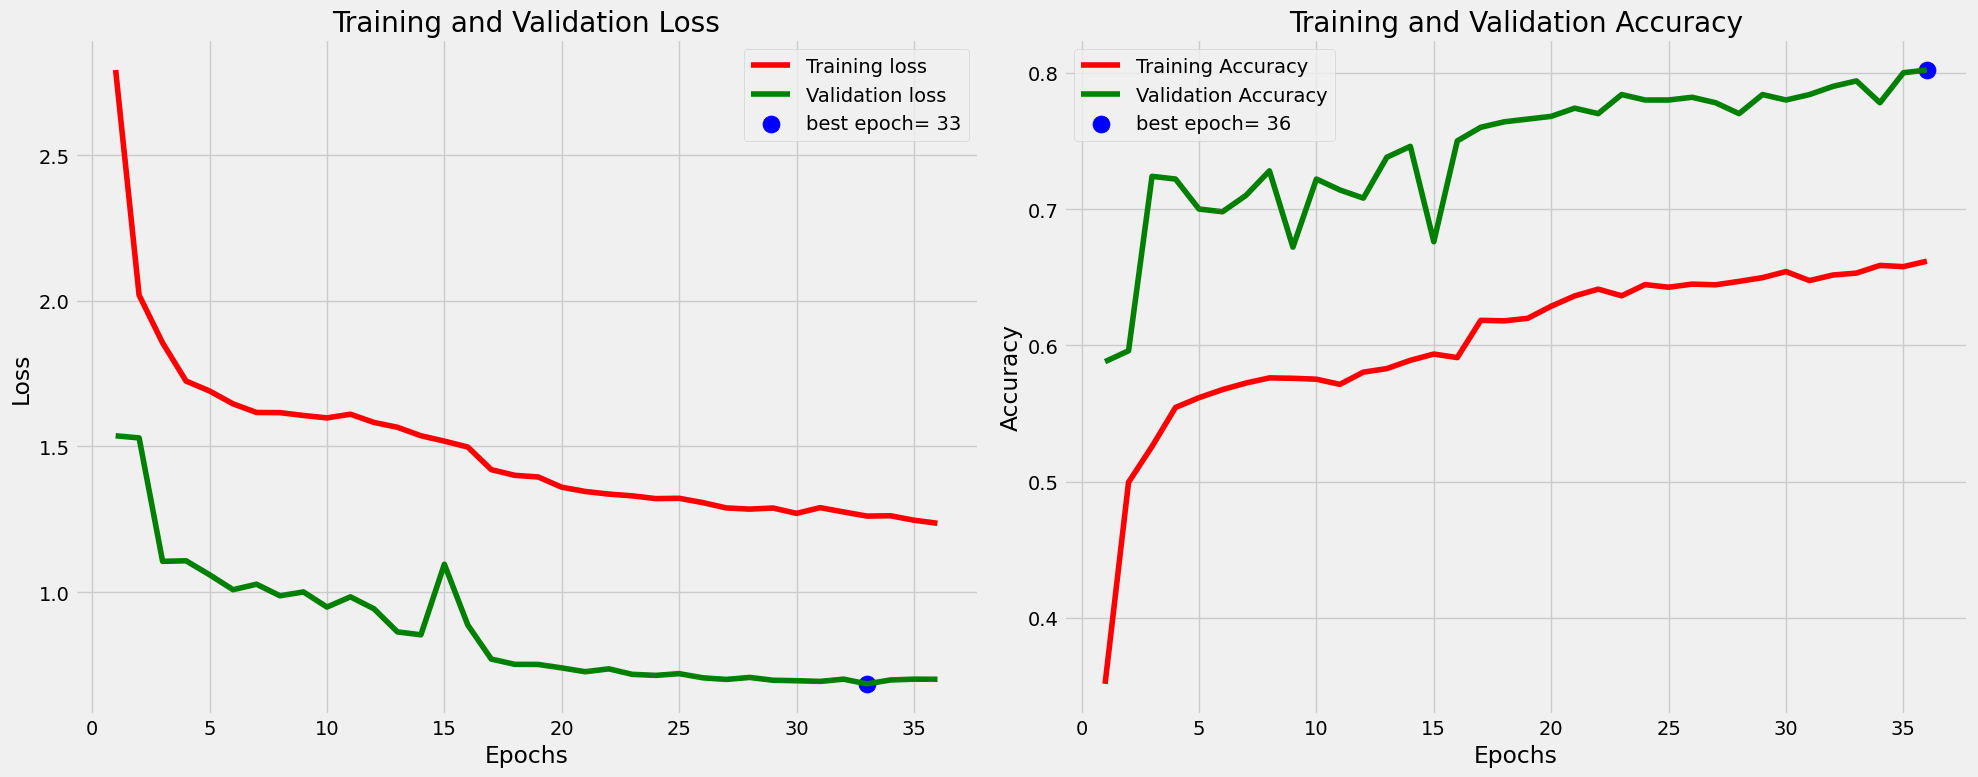

In [46]:
# Define needed variables
tr_acc = history_inception_v3.history['accuracy']
tr_loss = history_inception_v3.history['loss']
val_acc = history_inception_v3.history['val_accuracy']
val_loss = history_inception_v3.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



Model Evaluate

In [47]:
results = model_inception_v3.evaluate(test_images_inception_v3, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.59478
Test Accuracy: 81.60%


F1 Score / Recall / Precision

In [48]:
y_true = test_images_inception_v3.classes
y_pred = np.argmax(model_inception_v3.predict(test_images_inception_v3), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_inception_v3.class_indices.keys()))

50/50 [==============================] - 3s 32ms/step
F1 Score: 0.8080223665223666
                       precision    recall  f1-score   support

           air hockey       1.00      0.40      0.57         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      0.80      0.89         5
         balance beam       0.83      1.00      0.91         5
        barell racing       0.50      1.00      0.67         5
             baseball       0.80      0.80      0.80         5
           basketball       0.33      0.20      0.25         5
       baton twirling       0.56      1.00      0.71         5
            bike polo       0.62      1.00      0.77         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.40      0.57         5
              bobsled       1.00  

In [49]:
#predict labels on InceptionV3 test_set
preds = model_inception_v3.predict(test_images_inception_v3)
y_pred = np.argmax(preds, axis=1)
true_classes = test_images_inception_v3.classes
class_labels = list(test_images_inception_v3.class_indices.keys())  # Class names

# Confusion Matrix
cm = confusion_matrix(true_classes, y_pred)

# Calculating the accuracy for each class
accuracies = cm.diagonal() / cm.sum(axis=1)

# Displaying class-specific accuracies
for class_label, accuracy in zip(class_labels, accuracies):
    print(f"{class_label}: {accuracy:.2%}")

50/50 [==============================] - 2s 33ms/step
air hockey: 40.00%
ampute football: 100.00%
archery: 100.00%
arm wrestling: 100.00%
axe throwing: 80.00%
balance beam: 100.00%
barell racing: 100.00%
baseball: 80.00%
basketball: 20.00%
baton twirling: 100.00%
bike polo: 100.00%
billiards: 100.00%
bmx: 40.00%
bobsled: 80.00%
bowling: 60.00%
boxing: 80.00%
bull riding: 60.00%
bungee jumping: 100.00%
canoe slamon: 100.00%
cheerleading: 80.00%
chuckwagon racing: 0.00%
cricket: 80.00%
croquet: 100.00%
curling: 80.00%
disc golf: 100.00%
fencing: 60.00%
field hockey: 100.00%
figure skating men: 100.00%
figure skating pairs: 60.00%
figure skating women: 100.00%
fly fishing: 100.00%
football: 100.00%
formula 1 racing: 100.00%
frisbee: 80.00%
gaga: 80.00%
giant slalom: 100.00%
golf: 100.00%
hammer throw: 80.00%
hang gliding: 100.00%
harness racing: 100.00%
high jump: 80.00%
hockey: 80.00%
horse jumping: 60.00%
horse racing: 80.00%
horseshoe pitching: 80.00%
hurdles: 80.00%
hydroplane racing:

#COMPARISON

In [50]:
import pandas as pd

data = {
    'Model': ['ResNet50', 'VGG19', 'MobileNetV3 Large', 'EfficientNetB0', 'InceptionV3'],
    'Accuracy': ["90 %", "84 %", "97 %", "96.40 %", "81.60 %"],
    'F1 Score': [0.9 , 0.84, 0.97, 0.96, 0.81 ],
    'Training Time': ["753.23s" , "527.62s", "966.06s", "5982.82s", "1745.15s" ]
}

df = pd.DataFrame(data)

# Sort the DataFrame by 'Accuracy' in descending order
df = df.sort_values(by='Accuracy', ascending=False)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the ranked table
print(df)

               Model Accuracy  F1 Score Training Time
0  MobileNetV3 Large     97 %      0.97       966.06s
1     EfficientNetB0  96.40 %      0.96      5982.82s
2           ResNet50     90 %      0.90       753.23s
3              VGG19     84 %      0.84       527.62s
4        InceptionV3  81.60 %      0.81      1745.15s
